# 蚁群算法解决TSP问题

## 1.相关库导入

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import math
import random

## 2.初始化

In [2]:
city_name = []
city_xy = []
with open('data2.txt','r',encoding='UTF-8') as f:
    lines = f.readlines()
    for line in lines:
        line = line.split('\n')[0]
        line = line.split(',')
        city_name.append(line[0])
        city_xy.append([float(line[1]), float(line[2])])
city_xy = np.array(city_xy)

# 读取城市距离
city_num = len(city_name)
dis = np.zeros((city_num, city_num))
for i in range(city_num):
    for j in range(city_num):
        if i != j:
            dis[i][j] = math.sqrt((city_xy[i][0] - city_xy[j][0]) ** 2 + (city_xy[i][1] - city_xy[j][1]) ** 2)
        else:
            dis[i][j] = 100000

# 中断循环标志
stopit = 0

# 蚂蚁数量
M = 100
alpha = 1
beta = 2
rou = 0.1 #挥发速度
iter = 0
epoch = 200
Q = 100
# 初始信息素矩阵
phe = np.ones((city_num, city_num))

# 候选集列表,存放蚁群的路径(一只蚂蚁一个路径)，一共是蚂蚁数量*城市数量
candidate = np.zeros((M, city_num)).astype(int) 

# path_best存放的是相应的，每次迭代后的最优路径，每次迭代只有一个值
path_best = np.zeros((epoch, city_num)) 

# 存放每次迭代的最优距离
dis_best = np.zeros(epoch)
# 倒数矩阵
eta = 1.0 / dis  

## 3.ACO算法

In [3]:
while iter <  epoch:
    # Step1：蚂蚁初始点选择
    if M <= city_num:
    # 生成一个随机起点列表，并且起点不重复
        candidate[:, 0] = np.random.permutation(range(city_num))[:M]
    else:
        # 蚂蚁比城市多，那就按照城市数量，进行分块处理
        delta = M - city_num
        flag = 0
        while delta > city_num:
            candidate[city_num*flag:city_num*(flag+1), 0] = np.random.permutation(range(city_num))[:]
            delta = delta - city_num
            flag = flag + 1
        candidate[city_num*(flag+1):M,0] = np.random.permutation(range(city_num))[:delta]

    # 每次迭代的N个蚂蚁的路线长度
    length = np.zeros(M)

    # Step2：每一只蚂蚁的下一个城市选择
    for i in range(M):
        # uk：未曾访问的城市
        uk = list(range(city_num))
        # 蚂蚁的起点
        visit = candidate[i, 0]
        uk.remove(visit)
        for j in range(1, city_num):#访问剩下的城市
            protrans = np.zeros(len(uk))#每次循环都更改当前没有访问的城市的转移概率矩阵1*30,1*29,1*28...
            # 下一城市的概率函数
            for k in range(len(uk)):
                # 计算概率公式的分子
                protrans[k] = np.power(phe[visit][uk[k]], alpha) * np.power(
                    eta[visit][uk[k]], beta)

            # 累计概率，轮盘赌选择法
            finalpro = (protrans / sum(protrans)).cumsum()
            finalpro -= np.random.rand()
            # 求出离随机数产生最近的索引值，这便是轮盘赌中第一个被选中的数值
            k = uk[list(finalpro > 0).index(True)]
            # 下一个访问城市的索引值
            candidate[i, j] = k

            uk.remove(k)
            length[i] += dis[visit][k]
            visit = k  # 更改出发点，继续选择下一个到达点
        length[i] += dis[visit][candidate[i, 0]]#最后一个城市和第一个城市的距离值也要加进去

    # Step3：更新最短路径
    # 第一次迭代直接选择最短路径
    if iter == 0:
        dis_best[iter] = length.min()
        path_best[iter] = candidate[length.argmin()].copy()
    else:
        # 当前路径都不如上一次的短，那就替换本次路径为上一次的
        if length.min() > dis_best[iter - 1]:
            dis_best[iter] = dis_best[iter - 1]
            path_best[iter] = path_best[iter - 1].copy()
            # 中断标志开始累计
            stopit = stopit + 1
        # 否则直接选择最短路径
        else:
            dis_best[iter] = length.min()
            path_best[iter] = candidate[length.argmin()].copy()
            # 中断标志清零
            stopit = 0

    #Step4：信息素更新
    #信息素的增加量矩阵
    delta_phe = np.zeros((city_num, city_num))
    # 城市之间的信息素增量
    for i in range(M):
        for j in range(city_num - 1):
            delta_phe[candidate[i, j]][candidate[i][j + 1]] += (Q+dis[candidate[i, j]][candidate[i, j + 1]]) / length[i]
        #最后一个城市和第一个城市的信息素增加量
        delta_phe[candidate[i, j + 1]][candidate[i, 0]] += (Q+dis[candidate[i, j]][candidate[i, j + 1]]) / length[i]
    #信息素更新的公式：
    phe = rou * phe + delta_phe

    iter += 1

    if stopit == 10:
        break

## 4.绘图

最优路径 [ 3.  9. 18. 11.  7.  8. 14. 15. 24. 25. 29. 26. 28. 27. 16. 17. 22. 23.
 12. 13.  4. 30.  5.  6.  1.  2. 21. 20. 19. 10.]
迭代 15 次后 求得最优解 434.9954552811153


c:\ProgramData\Miniconda3\envs\pytorch_gpu\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\Miniconda3\envs\pytorch_gpu\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 20339 (\N{CJK UNIFIED IDEOGRAPH-4F73}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\Miniconda3\envs\pytorch_gpu\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 36335 (\N{CJK UNIFIED IDEOGRAPH-8DEF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\Miniconda3\envs\pytorch_gpu\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 24452 (\N{CJK UNIFIED IDEOGRAPH-5F84}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


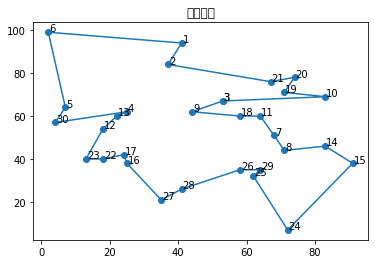

c:\ProgramData\Miniconda3\envs\pytorch_gpu\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 36845 (\N{CJK UNIFIED IDEOGRAPH-8FED}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\Miniconda3\envs\pytorch_gpu\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 20195 (\N{CJK UNIFIED IDEOGRAPH-4EE3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\Miniconda3\envs\pytorch_gpu\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 36317 (\N{CJK UNIFIED IDEOGRAPH-8DDD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\Miniconda3\envs\pytorch_gpu\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 31163 (\N{CJK UNIFIED IDEOGRAPH-79BB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\Miniconda3\envs\pytorch_gpu\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 22270 (\

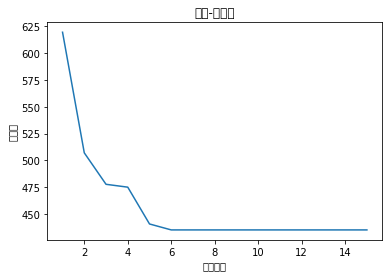

In [4]:
print("最优路径",path_best[iter-1]+1)
print("迭代", iter-1,"次后","求得最优解",dis_best[iter-1])

# 路线图绘制
fig = plt.figure()
plt.title("最佳路径")
x = []
y = []
path = []
for i in range(len(path_best[iter-1])):
    x.append(city_xy[int(path_best[iter-1][i])][0])
    y.append(city_xy[int(path_best[iter-1][i])][1])
    path.append(int(path_best[iter-1][i])+1)
x.append(x[0])
y.append(y[0])
path.append(path[0])
for i in range(len(x)):
    plt.annotate(path[i], xy=(x[i], y[i]), xytext=(x[i] + 0.3, y[i] + 0.3))
plt.plot(x, y,'-o')


fig = plt.figure()
plt.title("迭代-距离图")
plt.plot(range(1, iter-1 + 1), dis_best[:iter-1])
plt.xlabel("迭代次数")
plt.ylabel("距离值")
plt.show()

最优路径 [ 1.  2.  9.  3. 18. 11. 19. 21. 20. 10. 14. 15.  7.  8. 29. 26. 25. 24.
 27. 28. 16. 17. 22. 23. 12. 13.  4.  5. 30.  6.]
迭代 16 次后 求得最优解 431.47544435411146


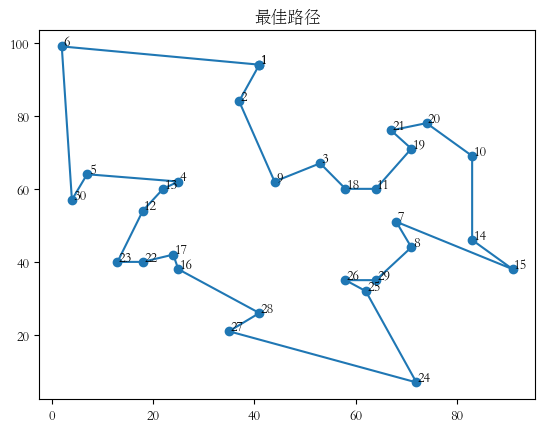

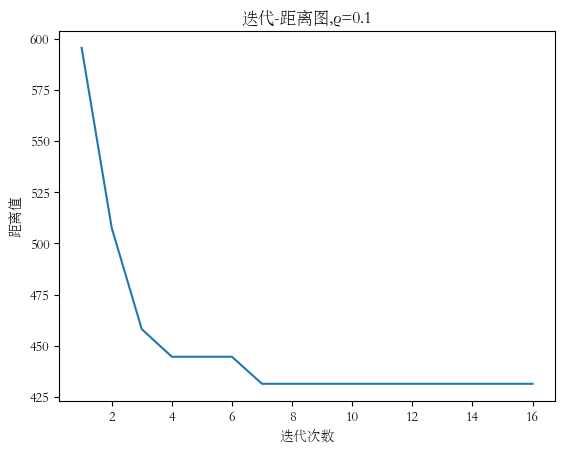

最优路径 [ 2.  9.  3. 18. 11. 19. 21. 20. 10.  7.  8. 14. 15. 24. 25. 26. 29. 28.
 27. 16. 17. 22. 23. 12. 13.  4.  5. 30.  6.  1.]
迭代 60 次后 求得最优解 427.4707725936543


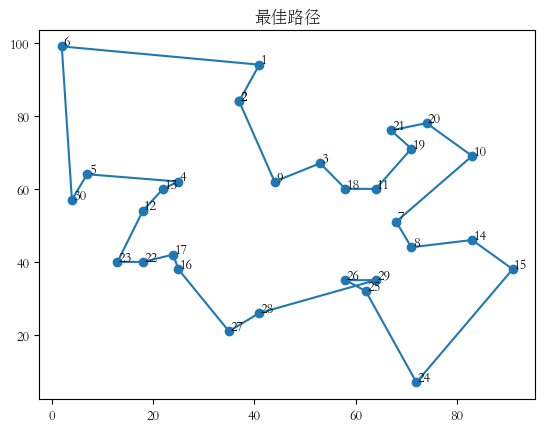

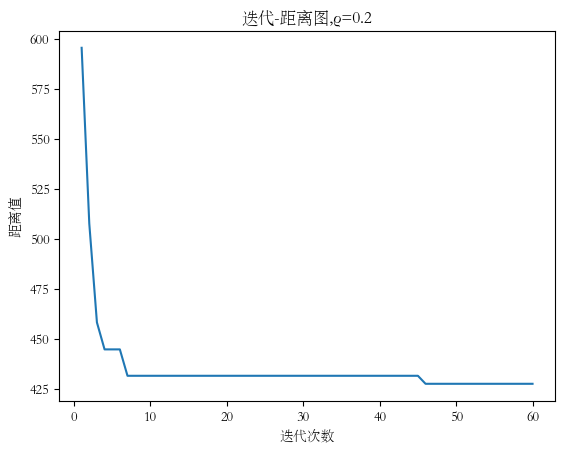

最优路径 [18. 11.  7.  8. 14. 15. 24. 29. 25. 26. 28. 27. 16. 17. 22. 23. 12. 13.
  4.  5. 30.  6.  1.  2.  9.  3. 21. 20. 10. 19.]
迭代 101 次后 求得最优解 426.02062824459387


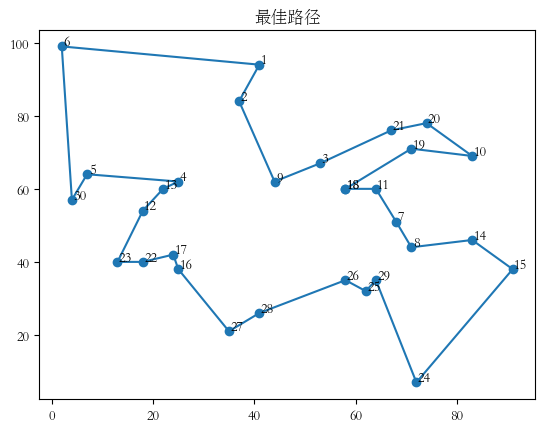

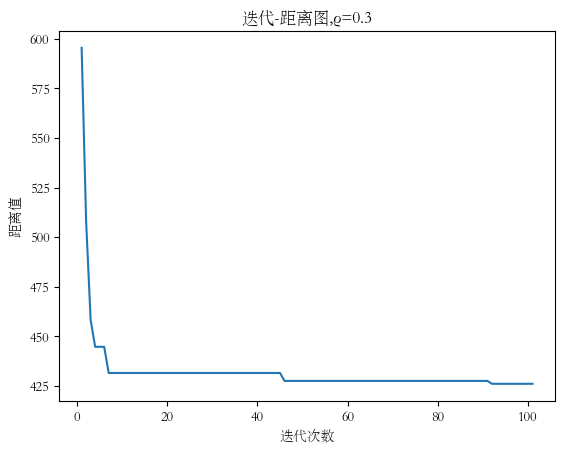

最优路径 [14. 15. 24. 29. 25. 26. 28. 27. 16. 17. 22. 23. 12. 13.  4.  5. 30.  6.
  1.  2.  9.  3. 21. 20. 10. 19. 11. 18.  7.  8.]
迭代 151 次后 求得最优解 425.63441293435045


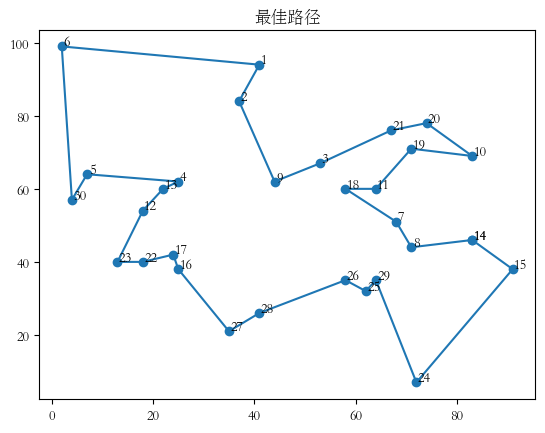

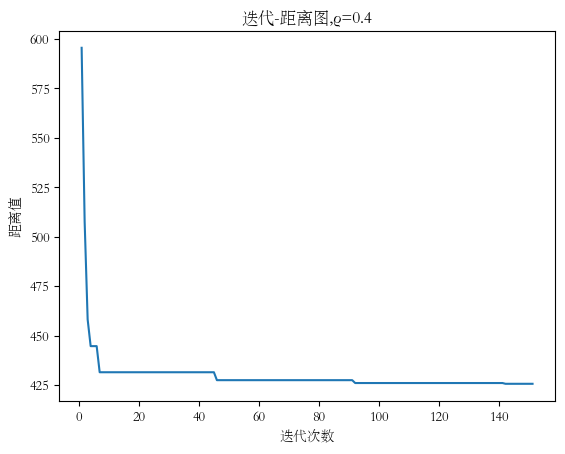

最优路径 [ 7.  8. 14. 15. 24. 29. 25. 26. 28. 27. 16. 17. 22. 23. 12. 13.  4.  5.
 30.  6.  1.  2.  9.  3. 18. 11. 19. 21. 20. 10.]
迭代 164 次后 求得最优解 421.80814538178237


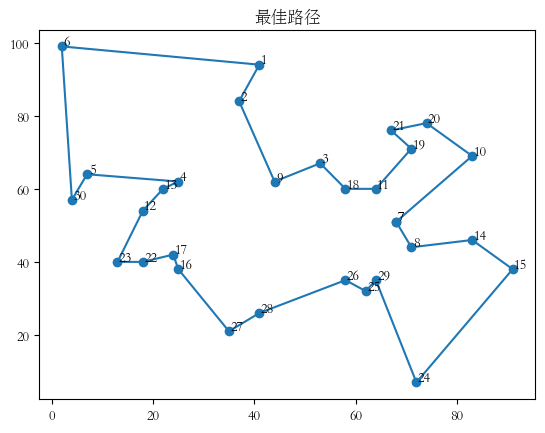

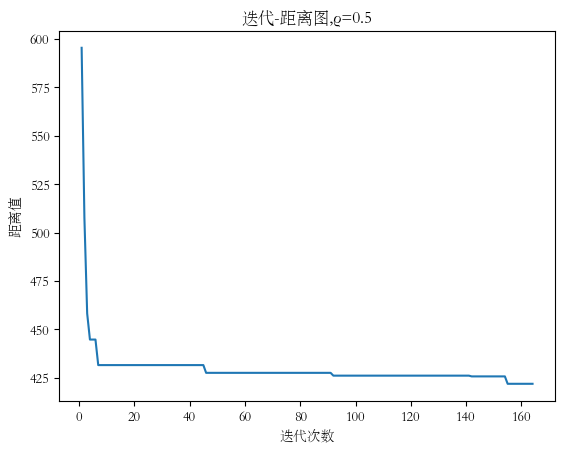

最优路径 [ 7.  8. 14. 15. 24. 29. 25. 26. 28. 27. 16. 17. 22. 23. 12. 13.  4.  5.
 30.  6.  1.  2.  9.  3. 18. 11. 19. 21. 20. 10.]
迭代 199 次后 求得最优解 421.80814538178237


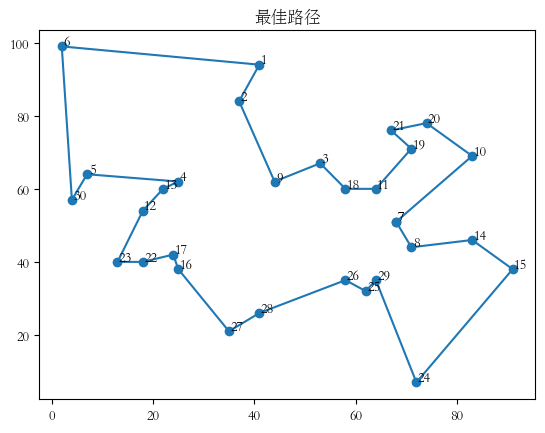

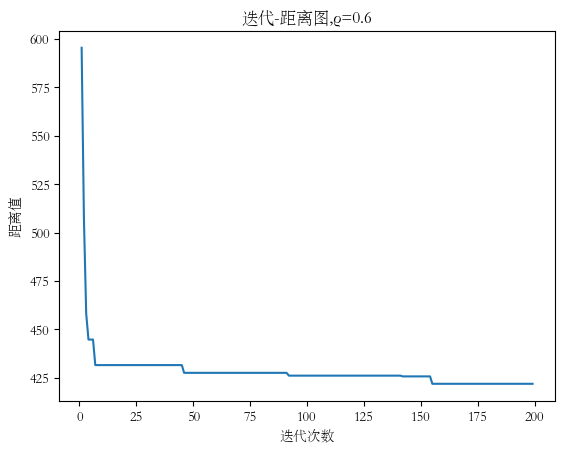

最优路径 [ 7.  8. 14. 15. 24. 29. 25. 26. 28. 27. 16. 17. 22. 23. 12. 13.  4.  5.
 30.  6.  1.  2.  9.  3. 18. 11. 19. 21. 20. 10.]
迭代 199 次后 求得最优解 421.80814538178237


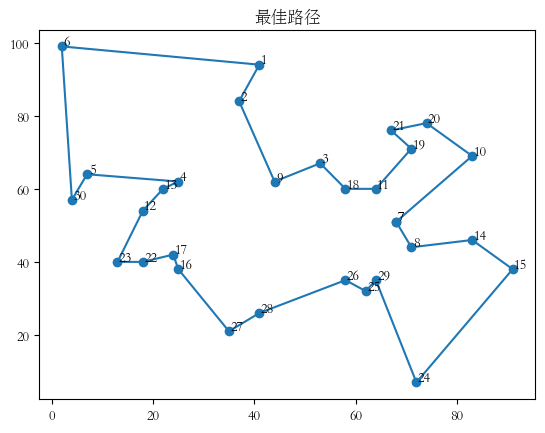

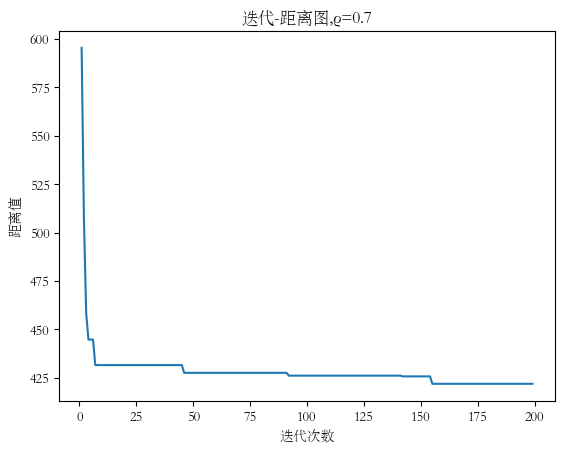

最优路径 [ 7.  8. 14. 15. 24. 29. 25. 26. 28. 27. 16. 17. 22. 23. 12. 13.  4.  5.
 30.  6.  1.  2.  9.  3. 18. 11. 19. 21. 20. 10.]
迭代 199 次后 求得最优解 421.80814538178237


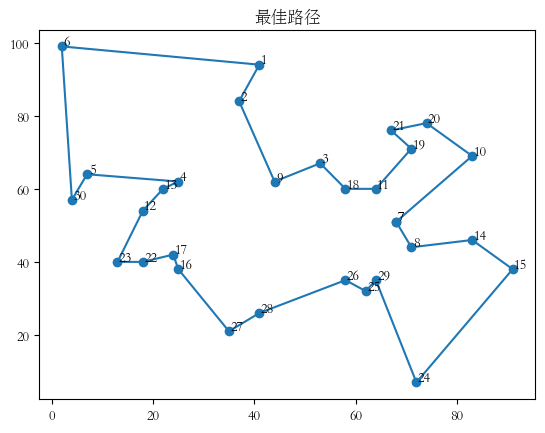

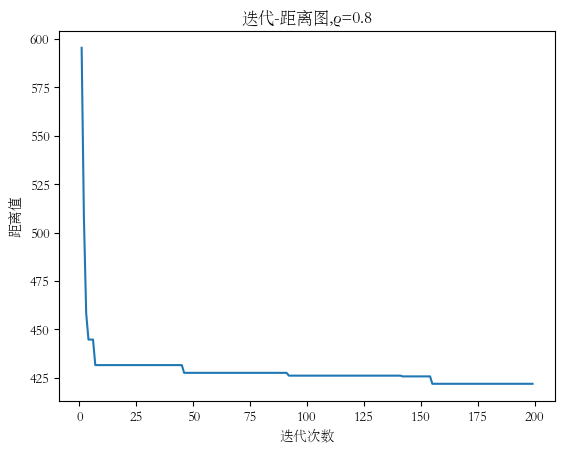

最优路径 [ 7.  8. 14. 15. 24. 29. 25. 26. 28. 27. 16. 17. 22. 23. 12. 13.  4.  5.
 30.  6.  1.  2.  9.  3. 18. 11. 19. 21. 20. 10.]
迭代 199 次后 求得最优解 421.80814538178237


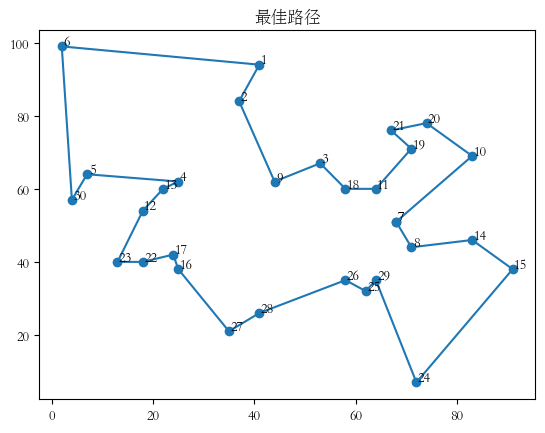

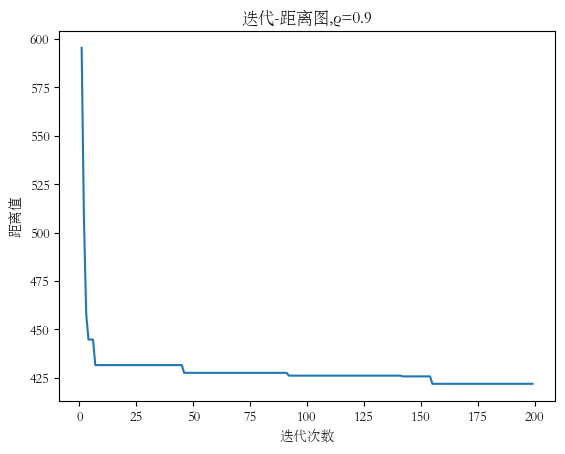

In [71]:
city_name = []
city_xy = []
with open('data2.txt','r',encoding='UTF-8') as f:
    lines = f.readlines()
    for line in lines:
        line = line.split('\n')[0]
        line = line.split(',')
        city_name.append(line[0])
        city_xy.append([float(line[1]), float(line[2])])
city_xy = np.array(city_xy)

# 读取城市距离
city_num = len(city_name)
dis = np.zeros((city_num, city_num))
for i in range(city_num):
    for j in range(city_num):
        if i != j:
            dis[i][j] = math.sqrt((city_xy[i][0] - city_xy[j][0]) ** 2 + (city_xy[i][1] - city_xy[j][1]) ** 2)
        else:
            dis[i][j] = 100000

# 中断循环标志
stopit = 0

# 蚂蚁数量
M = 100
alpha = 1
beta = 2
rous = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] #挥发速度
iter = 0
epoch = 200
Q = 100
# 初始信息素矩阵
phe = np.ones((city_num, city_num))

# 候选集列表,存放蚁群的路径(一只蚂蚁一个路径)，一共是蚂蚁数量*城市数量
candidate = np.zeros((M, city_num)).astype(int) 

# path_best存放的是相应的，每次迭代后的最优路径，每次迭代只有一个值
path_best = np.zeros((epoch, city_num)) 

# 存放每次迭代的最优距离
dis_best = np.zeros(epoch)
# 倒数矩阵
eta = 1.0 / dis  

for rou in rous:
    while iter <  epoch:
        # Step1：蚂蚁初始点选择
        if M <= city_num:
        # 生成一个随机起点列表，并且起点不重复
            candidate[:, 0] = np.random.permutation(range(city_num))[:M]
        else:
            # 蚂蚁比城市多，那就按照城市数量，进行分块处理
            delta = M - city_num
            flag = 0
            while delta > city_num:
                candidate[city_num*flag:city_num*(flag+1), 0] = np.random.permutation(range(city_num))[:]
                delta = delta - city_num
                flag = flag + 1
            candidate[city_num*(flag+1):M,0] = np.random.permutation(range(city_num))[:delta]

        # 每次迭代的N个蚂蚁的路线长度
        length = np.zeros(M)

        # Step2：每一只蚂蚁的下一个城市选择
        for i in range(M):
            # uk：未曾访问的城市
            uk = list(range(city_num))
            # 蚂蚁的起点
            visit = candidate[i, 0]
            uk.remove(visit)
            for j in range(1, city_num):#访问剩下的城市
                protrans = np.zeros(len(uk))#每次循环都更改当前没有访问的城市的转移概率矩阵1*30,1*29,1*28...
                # 下一城市的概率函数
                for k in range(len(uk)):
                    # 计算概率公式的分子
                    protrans[k] = np.power(phe[visit][uk[k]], alpha) * np.power(
                        eta[visit][uk[k]], beta)

                # 累计概率，轮盘赌选择法
                finalpro = (protrans / sum(protrans)).cumsum()
                finalpro -= np.random.rand()
                # 求出离随机数产生最近的索引值，这便是轮盘赌中第一个被选中的数值
                k = uk[list(finalpro > 0).index(True)]
                # 下一个访问城市的索引值
                candidate[i, j] = k

                uk.remove(k)
                length[i] += dis[visit][k]
                visit = k  # 更改出发点，继续选择下一个到达点
            length[i] += dis[visit][candidate[i, 0]]#最后一个城市和第一个城市的距离值也要加进去

        # Step3：更新最短路径
        # 第一次迭代直接选择最短路径
        if iter == 0:
            dis_best[iter] = length.min()
            path_best[iter] = candidate[length.argmin()].copy()
        else:
            # 当前路径都不如上一次的短，那就替换本次路径为上一次的
            if length.min() > dis_best[iter - 1]:
                dis_best[iter] = dis_best[iter - 1]
                path_best[iter] = path_best[iter - 1].copy()
                # 中断标志开始累计
                stopit = stopit + 1
            # 否则直接选择最短路径
            else:
                dis_best[iter] = length.min()
                path_best[iter] = candidate[length.argmin()].copy()
                # 中断标志清零
                stopit = 0

        #Step4：信息素更新
        #信息素的增加量矩阵
        delta_phe = np.zeros((city_num, city_num))
        # 城市之间的信息素增量
        for i in range(M):
            for j in range(city_num - 1):
                delta_phe[candidate[i, j]][candidate[i][j + 1]] += (Q+dis[candidate[i, j]][candidate[i, j + 1]]) / length[i]
            #最后一个城市和第一个城市的信息素增加量
            delta_phe[candidate[i, j + 1]][candidate[i, 0]] += (Q+dis[candidate[i, j]][candidate[i, j + 1]]) / length[i]
        #信息素更新的公式：
        phe = rou * phe + delta_phe

        iter += 1

        if stopit == 10:
            break
    print("最优路径",path_best[iter-1]+1)
    print("迭代", iter-1,"次后","求得最优解",dis_best[iter-1])

    # 路线图绘制
    fig = plt.figure()
    plt.title("最佳路径")
    x = []
    y = []
    path = []
    for i in range(len(path_best[iter-1])):
        x.append(city_xy[int(path_best[iter-1][i])][0])
        y.append(city_xy[int(path_best[iter-1][i])][1])
        path.append(int(path_best[iter-1][i])+1)
    x.append(x[0])
    y.append(y[0])
    path.append(path[0])
    for i in range(len(x)):
        plt.annotate(path[i], xy=(x[i], y[i]), xytext=(x[i] + 0.3, y[i] + 0.3))
    plt.plot(x, y,'-o')


    fig = plt.figure()
    plt.title("迭代-距离图,ρ=" + str(rou))
    plt.plot(range(1, iter-1 + 1), dis_best[:iter-1])
    plt.xlabel("迭代次数")
    plt.ylabel("距离值")
    plt.show()

最优路径 [25. 29. 26. 28. 27. 16. 17. 22. 23. 12. 13.  4.  5. 30.  6.  1.  2.  9.
  3. 18. 11. 19. 21. 20. 10.  7.  8. 14. 15. 24.]
迭代 41 次后 求得最优解 420.6135298603328


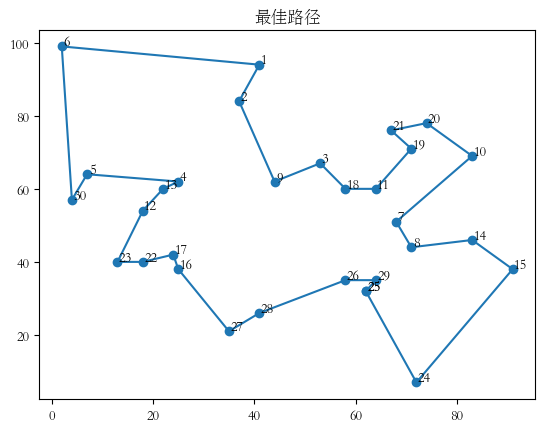

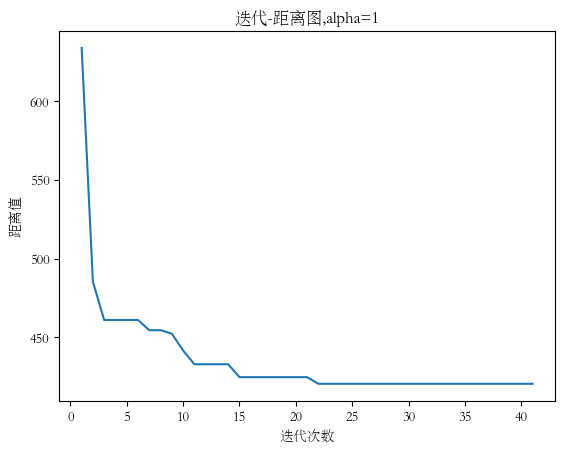

最优路径 [ 7.  8. 14. 15. 24. 25. 29. 26. 28. 27. 16. 17. 22. 23. 12. 13.  4.  5.
 30.  6.  1.  2.  9.  3. 18. 11. 19. 21. 20. 10.]
迭代 92 次后 求得最优解 420.6135298603328


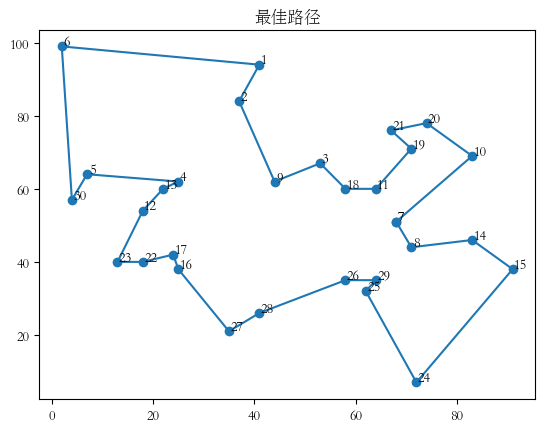

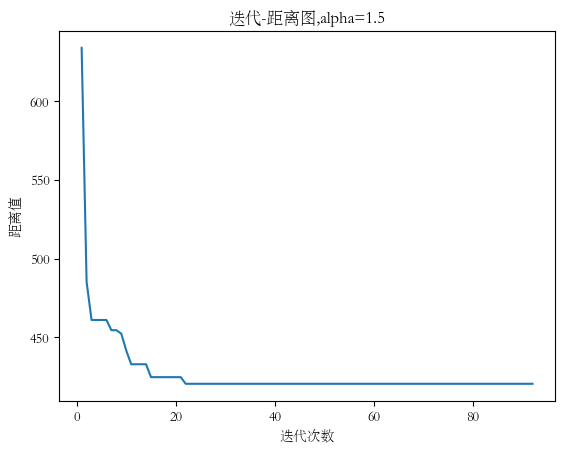

最优路径 [ 7.  8. 14. 15. 24. 25. 29. 26. 28. 27. 16. 17. 22. 23. 12. 13.  4.  5.
 30.  6.  1.  2.  9.  3. 18. 11. 19. 21. 20. 10.]
迭代 199 次后 求得最优解 420.6135298603328


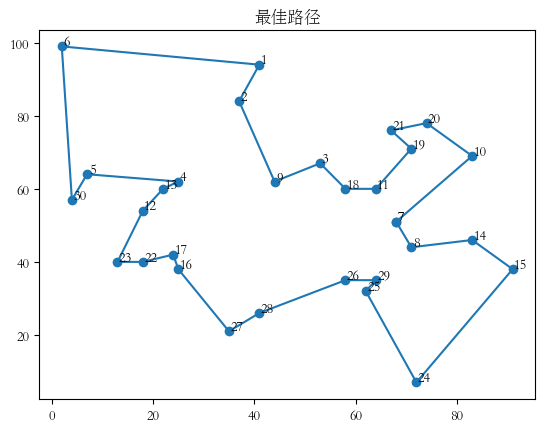

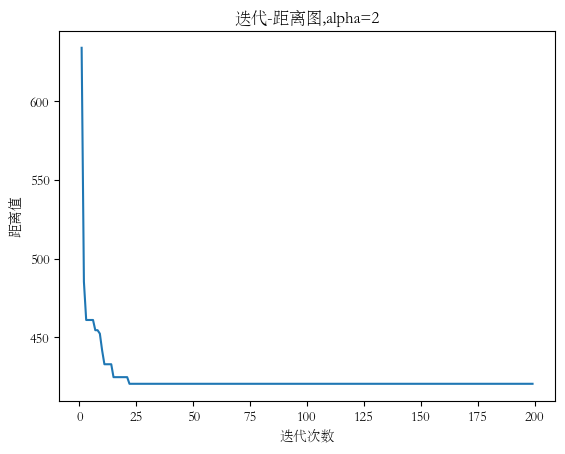

最优路径 [ 7.  8. 14. 15. 24. 25. 29. 26. 28. 27. 16. 17. 22. 23. 12. 13.  4.  5.
 30.  6.  1.  2.  9.  3. 18. 11. 19. 21. 20. 10.]
迭代 199 次后 求得最优解 420.6135298603328


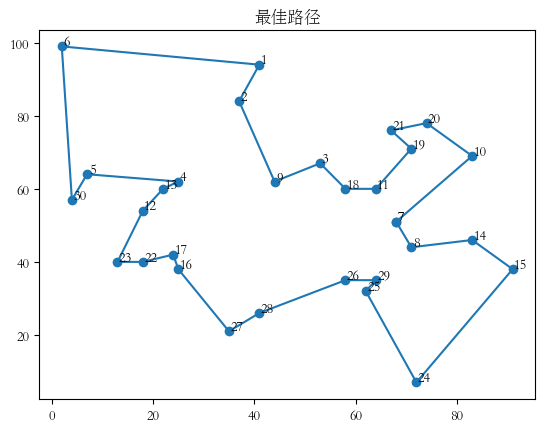

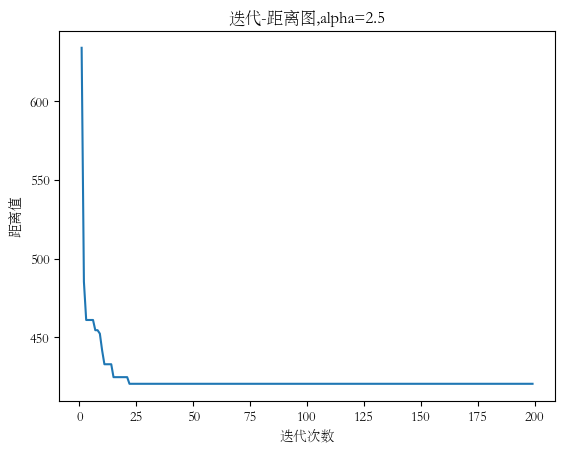

最优路径 [ 7.  8. 14. 15. 24. 25. 29. 26. 28. 27. 16. 17. 22. 23. 12. 13.  4.  5.
 30.  6.  1.  2.  9.  3. 18. 11. 19. 21. 20. 10.]
迭代 199 次后 求得最优解 420.6135298603328


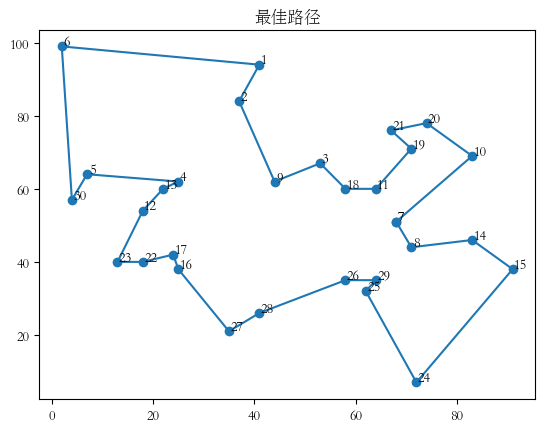

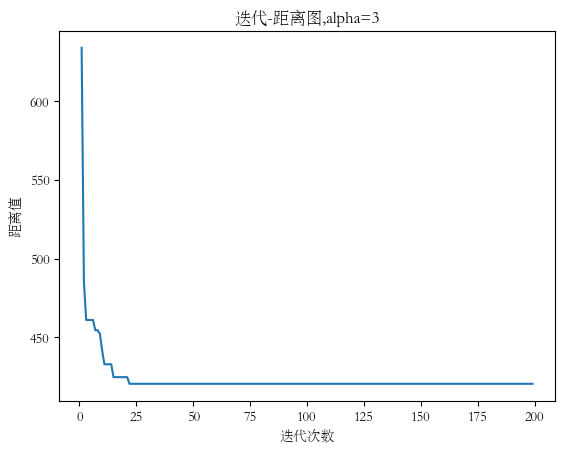

最优路径 [ 7.  8. 14. 15. 24. 25. 29. 26. 28. 27. 16. 17. 22. 23. 12. 13.  4.  5.
 30.  6.  1.  2.  9.  3. 18. 11. 19. 21. 20. 10.]
迭代 199 次后 求得最优解 420.6135298603328


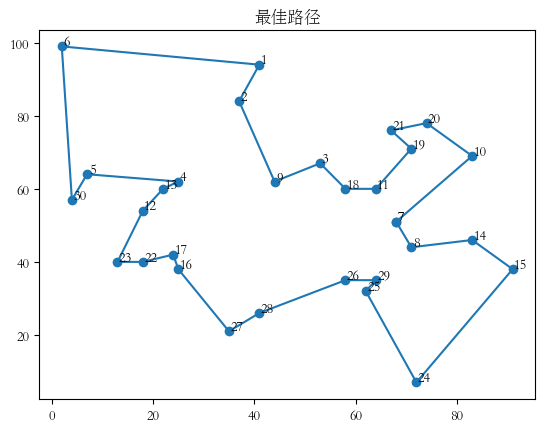

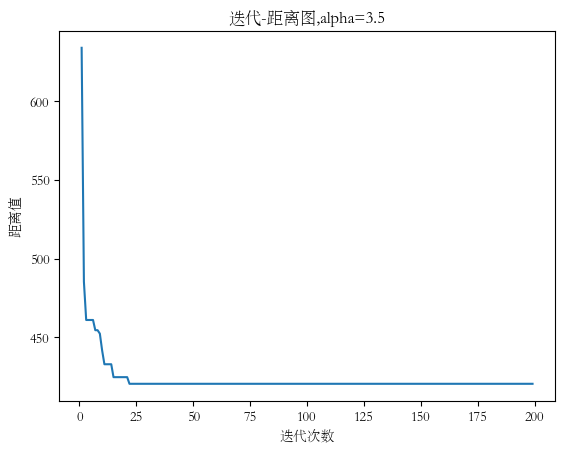

最优路径 [ 7.  8. 14. 15. 24. 25. 29. 26. 28. 27. 16. 17. 22. 23. 12. 13.  4.  5.
 30.  6.  1.  2.  9.  3. 18. 11. 19. 21. 20. 10.]
迭代 199 次后 求得最优解 420.6135298603328


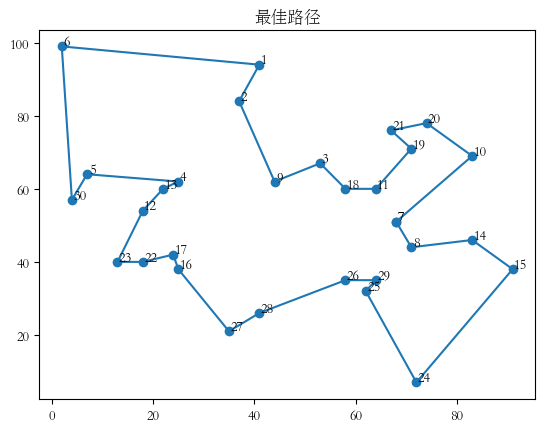

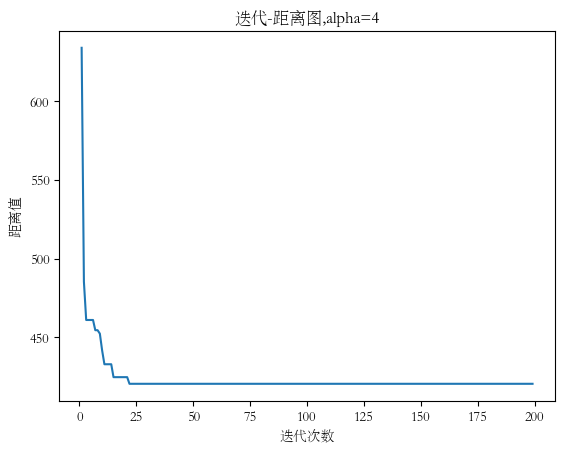

In [72]:
city_name = []
city_xy = []
with open('data2.txt','r',encoding='UTF-8') as f:
    lines = f.readlines()
    for line in lines:
        line = line.split('\n')[0]
        line = line.split(',')
        city_name.append(line[0])
        city_xy.append([float(line[1]), float(line[2])])
city_xy = np.array(city_xy)

# 读取城市距离
city_num = len(city_name)
dis = np.zeros((city_num, city_num))
for i in range(city_num):
    for j in range(city_num):
        if i != j:
            dis[i][j] = math.sqrt((city_xy[i][0] - city_xy[j][0]) ** 2 + (city_xy[i][1] - city_xy[j][1]) ** 2)
        else:
            dis[i][j] = 100000

# 中断循环标志
stopit = 0

# 蚂蚁数量
M = 100
# alphas = [1, 1.5, 2, 2.5, 3, 3.5, 4]
alpha
betas = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5 ,5]
rou = 0.5 #挥发速度
iter = 0
epoch = 200
Q = 100
# 初始信息素矩阵
phe = np.ones((city_num, city_num))

# 候选集列表,存放蚁群的路径(一只蚂蚁一个路径)，一共是蚂蚁数量*城市数量
candidate = np.zeros((M, city_num)).astype(int) 

# path_best存放的是相应的，每次迭代后的最优路径，每次迭代只有一个值
path_best = np.zeros((epoch, city_num)) 

# 存放每次迭代的最优距离
dis_best = np.zeros(epoch)
# 倒数矩阵
eta = 1.0 / dis  

# for alpha in alphas:
for beta in betas:
    while iter <  epoch:
        # Step1：蚂蚁初始点选择
        if M <= city_num:
        # 生成一个随机起点列表，并且起点不重复
            candidate[:, 0] = np.random.permutation(range(city_num))[:M]
        else:
            # 蚂蚁比城市多，那就按照城市数量，进行分块处理
            delta = M - city_num
            flag = 0
            while delta > city_num:
                candidate[city_num*flag:city_num*(flag+1), 0] = np.random.permutation(range(city_num))[:]
                delta = delta - city_num
                flag = flag + 1
            candidate[city_num*(flag+1):M,0] = np.random.permutation(range(city_num))[:delta]

        # 每次迭代的N个蚂蚁的路线长度
        length = np.zeros(M)

        # Step2：每一只蚂蚁的下一个城市选择
        for i in range(M):
            # uk：未曾访问的城市
            uk = list(range(city_num))
            # 蚂蚁的起点
            visit = candidate[i, 0]
            uk.remove(visit)
            for j in range(1, city_num):#访问剩下的城市
                protrans = np.zeros(len(uk))#每次循环都更改当前没有访问的城市的转移概率矩阵1*30,1*29,1*28...
                # 下一城市的概率函数
                for k in range(len(uk)):
                    # 计算概率公式的分子
                    protrans[k] = np.power(phe[visit][uk[k]], alpha) * np.power(
                        eta[visit][uk[k]], beta)

                # 累计概率，轮盘赌选择法
                finalpro = (protrans / sum(protrans)).cumsum()
                finalpro -= np.random.rand()
                # 求出离随机数产生最近的索引值，这便是轮盘赌中第一个被选中的数值
                k = uk[list(finalpro > 0).index(True)]
                # 下一个访问城市的索引值
                candidate[i, j] = k

                uk.remove(k)
                length[i] += dis[visit][k]
                visit = k  # 更改出发点，继续选择下一个到达点
            length[i] += dis[visit][candidate[i, 0]]#最后一个城市和第一个城市的距离值也要加进去

        # Step3：更新最短路径
        # 第一次迭代直接选择最短路径
        if iter == 0:
            dis_best[iter] = length.min()
            path_best[iter] = candidate[length.argmin()].copy()
        else:
            # 当前路径都不如上一次的短，那就替换本次路径为上一次的
            if length.min() > dis_best[iter - 1]:
                dis_best[iter] = dis_best[iter - 1]
                path_best[iter] = path_best[iter - 1].copy()
                # 中断标志开始累计
                stopit = stopit + 1
            # 否则直接选择最短路径
            else:
                dis_best[iter] = length.min()
                path_best[iter] = candidate[length.argmin()].copy()
                # 中断标志清零
                stopit = 0

        #Step4：信息素更新
        #信息素的增加量矩阵
        delta_phe = np.zeros((city_num, city_num))
        # 城市之间的信息素增量
        for i in range(M):
            for j in range(city_num - 1):
                delta_phe[candidate[i, j]][candidate[i][j + 1]] += (Q+dis[candidate[i, j]][candidate[i, j + 1]]) / length[i]
            #最后一个城市和第一个城市的信息素增加量
            delta_phe[candidate[i, j + 1]][candidate[i, 0]] += (Q+dis[candidate[i, j]][candidate[i, j + 1]]) / length[i]
        #信息素更新的公式：
        phe = rou * phe + delta_phe

        iter += 1

        if stopit == 10:
            break
    print("最优路径",path_best[iter-1]+1)
    print("迭代", iter-1,"次后","求得最优解",dis_best[iter-1])

    # 路线图绘制
    fig = plt.figure()
    plt.title("最佳路径")
    x = []
    y = []
    path = []
    for i in range(len(path_best[iter-1])):
        x.append(city_xy[int(path_best[iter-1][i])][0])
        y.append(city_xy[int(path_best[iter-1][i])][1])
        path.append(int(path_best[iter-1][i])+1)
    x.append(x[0])
    y.append(y[0])
    path.append(path[0])
    for i in range(len(x)):
        plt.annotate(path[i], xy=(x[i], y[i]), xytext=(x[i] + 0.3, y[i] + 0.3))
    plt.plot(x, y,'-o')


    fig = plt.figure()
    plt.title("迭代-距离图,beta=" + str(beta))
    plt.plot(range(1, iter-1 + 1), dis_best[:iter-1])
    plt.xlabel("迭代次数")
    plt.ylabel("距离值")
    plt.show()